# Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий

**Цель:** изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык **Python** и библиотеки **PM4PY**, **Pandas**.

**Данные:**

## Начало работы. Чтение журнала событий

Библиотека **pm4py** работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:
- **converter** из `pm4py.objects.conversion.log` (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий; 
- **importer** из `pm4py.objects.log.importer.xes` (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки `pm4py.objects.conversion.log.converter` преобразуем его в журнал событий.


In [51]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [8]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('https://raw.githubusercontent.com/Adelaaas/Process_mining_lab_hes/main/ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [9]:
type(log_csv)

pandas.core.frame.DataFrame

**Перед началом работы с любым набором данных, необходимо сначала его изучить:**
- названия колонок
- типы данных
- пропущенные значения
- и другое

In [10]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [11]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [12]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [13]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [14]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

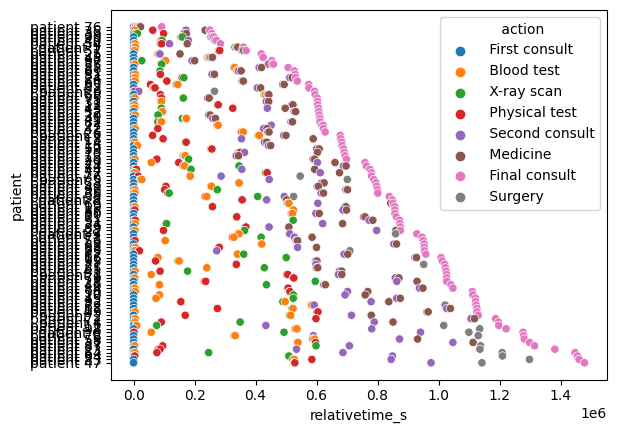

In [15]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [16]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [17]:
len(log_csv['patient'].unique())

100

In [18]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

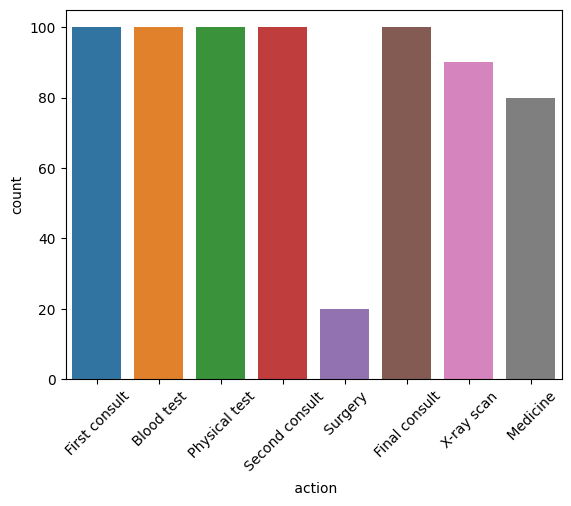

In [19]:
sns.countplot(x=log_csv[' action'])
plt.xticks(rotation=45)

In [20]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

**Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:**

- **Идентификатор случая (case id):** хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- **Деятельность (activity name):** хранит действия, выполняемые в рамках событий журнала.
- **Отметка времени (timestamp):** хранит дату и время регистрации событий журнала.
- **Ресурс (resource):** хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- **Прочее (other data):** сюда попадает вся оставшаяся в журнале (не интересная нам) информация. 

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [21]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [22]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [23]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [24]:
log_csv.shape

(690, 10)

In [25]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [26]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [27]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [28]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [29]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [30]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [31]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

## Построение модели по журналу событий

### Alpha Miner

**Alpha miner** — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [32]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

Полученный процесс мы можем отобразить с помощью **Сетей Петри**.

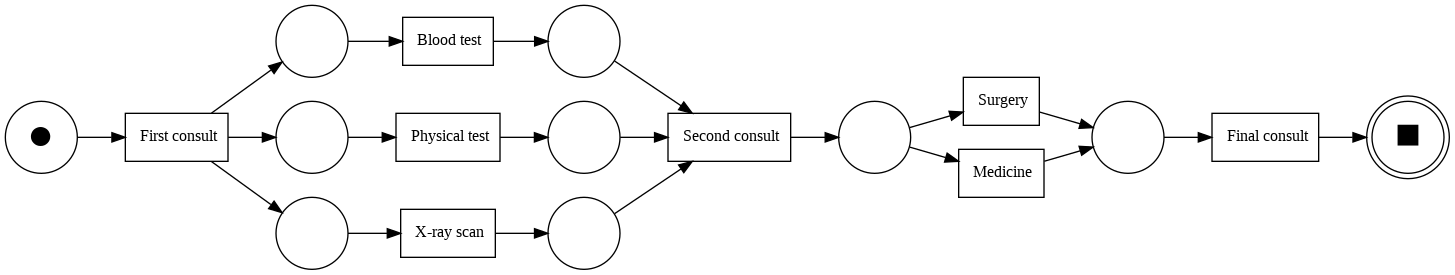

In [33]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр `pn_visualizer.Variants.FREQUENCY` при вызове `pn_visualizer.apply()`.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

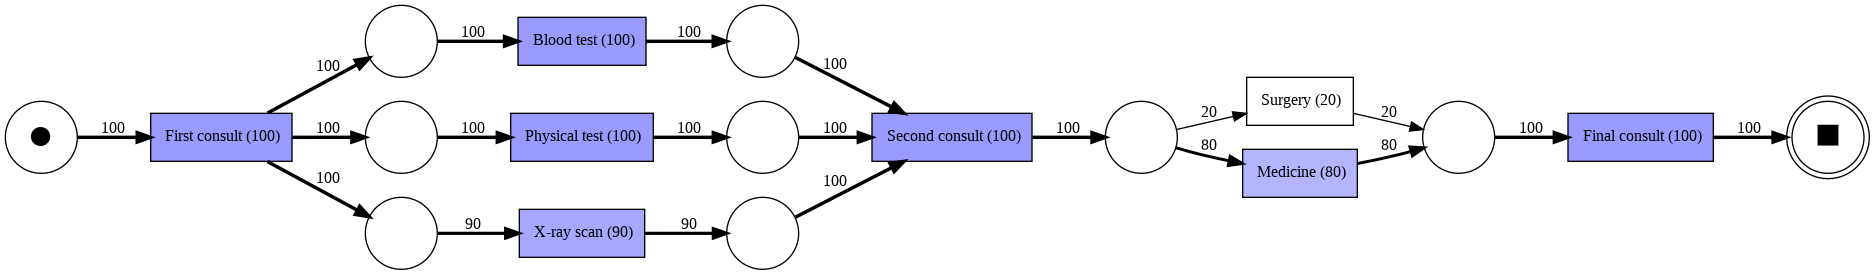

In [34]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [35]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция `get_transition_performance_with_token_replay` принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [36]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [37]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( X-ray scan, ' X-ray scan')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [38]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

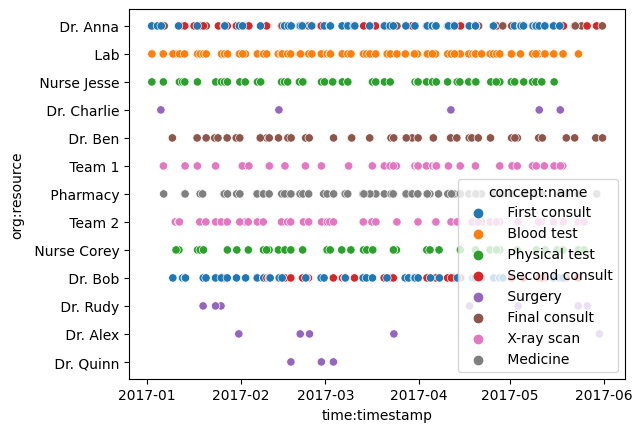

In [39]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

## Задания. Изучение журнала событий

1. Каково минимальное и максимальное количество событий в одном случае?
2. Какие события являются общими для всех процессов?
3. Найдите наибоее часто встречающуюся последовательность событий.
4. Какой пациент на лечение тратил меньше всего времени, а какой больше?
6. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
7. Pation 13 с каким врачом/врачами он/она консультировался?
8. Какое событие является наиболее ресурсоёмким в данном журнале событий?
9. Есть ли врачи или медсестры, которые перегружены работой?
10. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
11. Какие события связаны с узкими местами и какие ресурсы задействованы?
12. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

## Задание. Обнаружение модели процессов

1. По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.
Для каждой модели постройте сети Петри, сравните и сделайте вывод о том, какая модель больше всего подходит в данной задаче (привести значения различных метрик).


# Выполнение лабораторной работы 

Задание 1: Каково минимальное и максимальное количество событий в одном случае?


In [40]:
print(f"Минимальное количество событий ", min(log_csv.groupby('case:concept:name').count()['concept:name']))
print(f"Максимальное количество событий ", max(log_csv.groupby('case:concept:name').count()['concept:name']))


Минимальное количество событий  6
Максимальное количество событий  7


Задание 2: Какие события являются общими для всех процессов?

In [41]:
from pm4py.algo.filtering.log.attributes import attributes_filter
common_events = attributes_filter.get_attribute_values(log_csv, 'concept:name')
common_events

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Задание 3: Найдите наибоее часто встречающуюся последовательность событий.

In [42]:
variants_count_often_met = case_statistics.get_variant_statistics(log_csv)[0]
variants_count_often_met

{'variant': (' First consult',
  ' Blood test',
  ' X-ray scan',
  ' Physical test',
  ' Second consult',
  ' Medicine',
  ' Final consult'),
 'count': 18}


Задание 4: Какой пациент на лечение тратил меньше всего времени, а какой больше?



In [45]:
print("Пациент потративший наибольшее количесвто времени на лечение", log_csv.groupby('case:concept:name')['relativetime_s'].sum().reset_index().query(f"relativetime_s == {max(log_csv.groupby('case:concept:name')['relativetime_s'].sum())}")) 
print("Пациент поративший наименьшее количесвто времени на лечение", log_csv.groupby('case:concept:name')['relativetime_s'].sum().reset_index().query(f"relativetime_s == {min(log_csv.groupby('case:concept:name')['relativetime_s'].sum())}"))

Пациент потративший наибольшее количесвто времени на лечение    case:concept:name  relativetime_s
82        patient 83         5237888
Пациент поративший наименьшее количесвто времени на лечение    case:concept:name  relativetime_s
74        patient 76          163885


Задание 5: Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)


In [46]:
log_csv['NumActions in Case'] = log_csv.groupby('case:concept:name').cumcount()+1
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,1
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,2
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,3
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,4
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,5
...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,3
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,4
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,5
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,6


Задание 6: Patient 13 с каким врачом/врачами он/она консультировался?

In [55]:
from pm4py.algo.filtering.pandas.attributes import attributes_filter
Patient13 = attributes_filter.apply(log_csv, ["patient 13"],
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "case:concept:name", 
                                                      attributes_filter.Parameters.POSITIVE: True})
Patient13

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34,1
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34,2
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34,3
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34,4
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34,5
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34,6
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34,7


Задание 7: Какое событие является наиболее ресурсоёмким в данном журнале событий?

In [56]:
log_csv.query(f"relativetime_s == {max(log_csv['relativetime_s'])}")

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
327,patient 47,Final consult,Dr. Anna,2017-03-27 12:10:48,2017-03-27 12:10:48,2017-03-10 09:27:44,17 days 02:43:04,1478584,17,17 days 02:43:04,7


Задание 8: Есть ли врачи или медсестры, которые перегружены работой?

In [57]:
grouped_data = log_csv.groupby('org:resource').agg({'caselength': 'sum'})
print(grouped_data.nlargest(3, 'caselength'))

                     caselength
org:resource                   
 Dr. Anna    1549 days 23:50:20
 Lab          957 days 16:54:04
 Dr. Bob      867 days 09:46:35


Задание 9:Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

In [61]:
event_sorted_by_resource = log_csv.groupby('org:resource')['concept:name'].nunique()
total_events = event_sorted_by_resource.sum()
event_share_by_resource = event_sorted_by_resource / total_events
print(event_share_by_resource)

org:resource
 Dr. Alex       0.0625
 Dr. Anna       0.1875
 Dr. Ben        0.0625
 Dr. Bob        0.1250
 Dr. Charlie    0.0625
 Dr. Quinn      0.0625
 Dr. Rudy       0.0625
 Lab            0.0625
 Nurse Corey    0.0625
 Nurse Jesse    0.0625
 Pharmacy       0.0625
 Team 1         0.0625
 Team 2         0.0625
Name: concept:name, dtype: float64


Задание 10: Какие события связаны с узкими местами и какие ресурсы задействованы?

In [59]:
import pandas as pd
import numpy as np

seconds_to_hours = 60*60
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)
log_csv['time'] = log_csv['time'] / seconds_to_hours
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["time"],
               aggfunc=np.sum)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

Задание 11: Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

In [62]:
from pm4py.objects.petri_net.utils.performance_map import mean
import pm4py
tracefilter_log_pos = pm4py.filter_event_attribute_values(log_csv, "NumActions in Case", [2], level="event", retain=True)

print("Среднее время между первой консультацией и следующим шагом лечения ", mean(tracefilter_log_pos['relativetime_s']))
print("Максимальное время ", max(tracefilter_log_pos['relativetime_s']))
print("Минимальное время ", min(tracefilter_log_pos['relativetime_s']))

Среднее время между первой консультацией и следующим шагом лечения  133638.24
Максимальное время  587118
Минимальное время  1324


<Axes: xlabel='relativetime_s', ylabel='case:concept:name'>

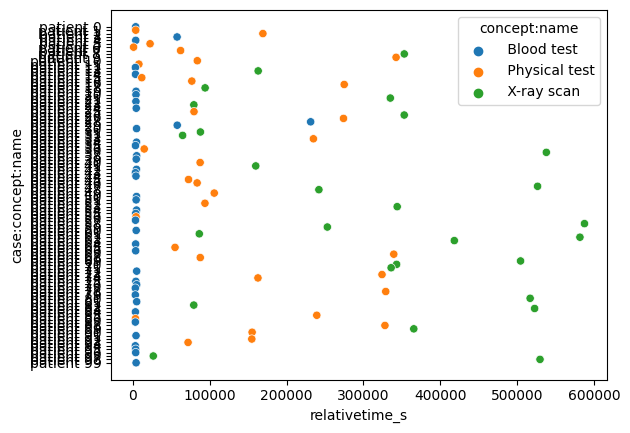

In [63]:
sns.scatterplot(x=tracefilter_log_pos['relativetime_s'], y=tracefilter_log_pos['case:concept:name'], hue=tracefilter_log_pos['concept:name'])

Задание 12: Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA. Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis